In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import matplotlib.colors as colors
%matplotlib inline

In [2]:
from pyquil import Program, get_qc
from pyquil.gates import CZ, H, I, X, MEASURE
from pyquil.quilbase import Declare
from scipy.linalg import expm

In [3]:
qc = get_qc('2q-qvm')

In [4]:
def damping_channel(damp_prob=.1):
    """
    Generate the Kraus operators corresponding to an amplitude damping
    noise channel.

    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1],
                                                [0, 0]])

    residual_kraus = np.diag([1, np.sqrt(1-damp_prob)])
    return [residual_kraus, damping_op]

def append_kraus_to_gate(kraus_ops, g):
    """
    Follow a gate `g` by a Kraus map described by `kraus_ops`.

    :param list kraus_ops: The Kraus operators.
    :param numpy.ndarray g: The unitary gate.
    :return: A list of transformed Kraus operators.
    """
    return [kj.dot(g) for kj in kraus_ops]


def append_damping_to_gate(gate, damp_prob=.1):
    """
    Generate the Kraus operators corresponding to a given unitary
    single qubit gate followed by an amplitude damping noise channel.

    :params np.ndarray|list gate: The 2x2 unitary gate matrix.
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return append_kraus_to_gate(damping_channel(damp_prob), gate)

In [5]:
%%time

# single step damping probability
damping_per_I = 0.02

# number of program executions
trials = 200

results_damping = []
lengths = np.arange(0, 201, 10, dtype=int)
for jj, num_I in enumerate(lengths):
    print("\r{}/{}, ".format(jj, len(lengths)), end="")


    p = Program(
        Declare("ro", "BIT", 1),
        X(0),
    )
    # want increasing number of I-gates
    p.inst([I(0) for _ in range(num_I)])
    p.inst(MEASURE(0, ("ro", 0)))

    # overload identity I on qc 0
    p.define_noisy_gate("I", [0], append_damping_to_gate(np.eye(2), damping_per_I))
    p.wrap_in_numshots_loop(trials)
    qc.qam.random_seed = int(num_I)
    res = qc.run(p).readout_data.get("ro")
    results_damping.append([np.mean(res), np.std(res) / np.sqrt(trials)])

results_damping = np.array(results_damping)

20/21, CPU times: total: 46.9 ms
Wall time: 2.7 s


In [6]:
dense_lengths = np.arange(0, lengths.max()+1, .2)
survival_probs = (1-damping_per_I)**dense_lengths
logpmf = binom.logpmf(np.arange(trials+1)[np.newaxis, :], trials, survival_probs[:, np.newaxis])/np.log(10)

In [7]:
DARK_TEAL = '#48737F'
FUSCHIA = "#D6619E"
BEIGE = '#EAE8C6'
cm = colors.LinearSegmentedColormap.from_list('anglemap', ["white", FUSCHIA, BEIGE], N=256, gamma=1.5)

(0.0, 1.0)

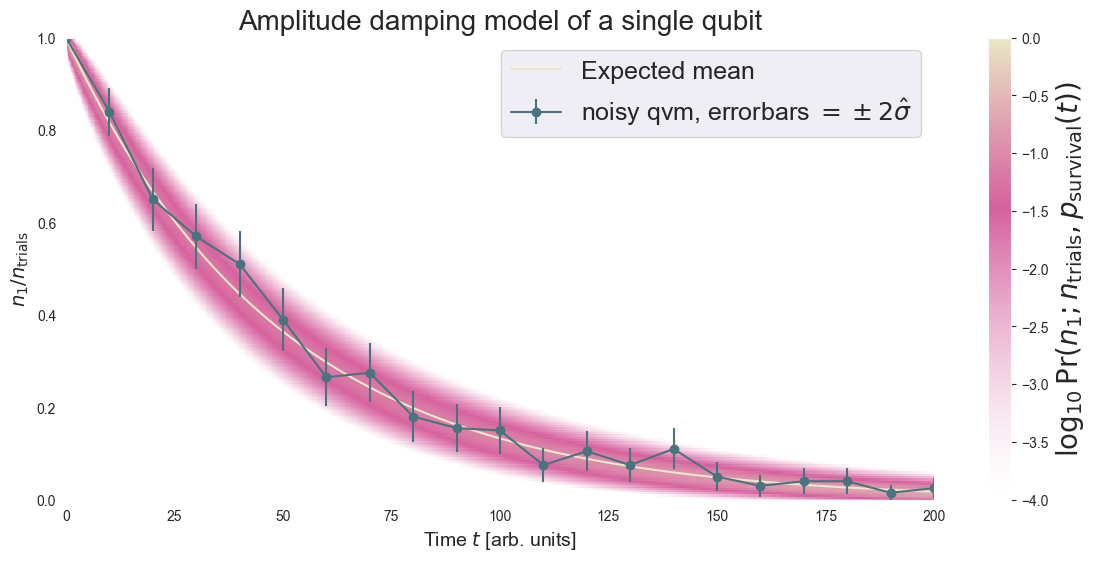

In [8]:
plt.figure(figsize=(14, 6))
plt.pcolor(dense_lengths, np.arange(trials+1)/trials, logpmf.T, cmap=cm, vmin=-4, vmax=logpmf.max())
plt.plot(dense_lengths, survival_probs, c=BEIGE, label="Expected mean")
plt.errorbar(lengths, results_damping[:,0], yerr=2*results_damping[:,1], c=DARK_TEAL,
             label=r"noisy qvm, errorbars $ = \pm 2\hat{\sigma}$", marker="o")
cb = plt.colorbar()
cb.set_label(r"$\log_{10} \mathrm{Pr}(n_1; n_{\rm trials}, p_{\rm survival}(t))$", size=20)

plt.title("Amplitude damping model of a single qubit", size=20)
plt.xlabel(r"Time $t$ [arb. units]", size=14)
plt.ylabel(r"$n_1/n_{\rm trials}$", size=14)
plt.legend(loc="best", fontsize=18)
plt.xlim(*lengths[[0, -1]])
plt.ylim(0, 1)

In [9]:
def dephasing_kraus_map(p=.1):
    """
    Generate the Kraus operators corresponding to a dephasing channel.

    :params float p: The one-step dephasing probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return [np.sqrt(1-p)*np.eye(2), np.sqrt(p)*np.diag([1, -1])]

def tensor_kraus_maps(k1, k2):
    """
    Generate the Kraus map corresponding to the composition
    of two maps on different qubits.

    :param list k1: The Kraus operators for the first qubit.
    :param list k2: The Kraus operators for the second qubit.
    :return: A list of tensored Kraus operators.
    """
    return [np.kron(k1j, k2l) for k1j in k1 for k2l in k2]

In [10]:
%%time
# single step damping probabilities
ps = np.linspace(.001, .5, 200)

# number of program executions
trials = 500

results = []

for jj, p in enumerate(ps):

    corrupted_CZ = append_kraus_to_gate(
        tensor_kraus_maps(
            dephasing_kraus_map(p),
            dephasing_kraus_map(p)
        ),
        np.diag([1, 1, 1, -1]))


    print("\r{}/{}, ".format(jj, len(ps)), end="")

    # make Bell-state
    p = Program(
        Declare("ro", "BIT", 2),
        H(0),
        H(1),
        CZ(0, 1),
        H(1),
    )

    p.inst(MEASURE(0, ("ro", 0)))
    p.inst(MEASURE(1, ("ro", 1)))

    # overload CZ on qc 0
    p.define_noisy_gate("CZ", [0, 1], corrupted_CZ)
    p.wrap_in_numshots_loop(trials)
    qc.qam.random_seed = jj
    res = qc.run(p).readout_data.get("ro")
    results.append(res)

results = np.array(results)

199/200, CPU times: total: 906 ms
Wall time: 7.04 s


In [11]:
Z1s = (2*results[:,:,0]-1.)
Z2s = (2*results[:,:,1]-1.)
Z1Z2s = Z1s * Z2s

Z1m = np.mean(Z1s, axis=1)
Z2m = np.mean(Z2s, axis=1)
Z1Z2m = np.mean(Z1Z2s, axis=1)

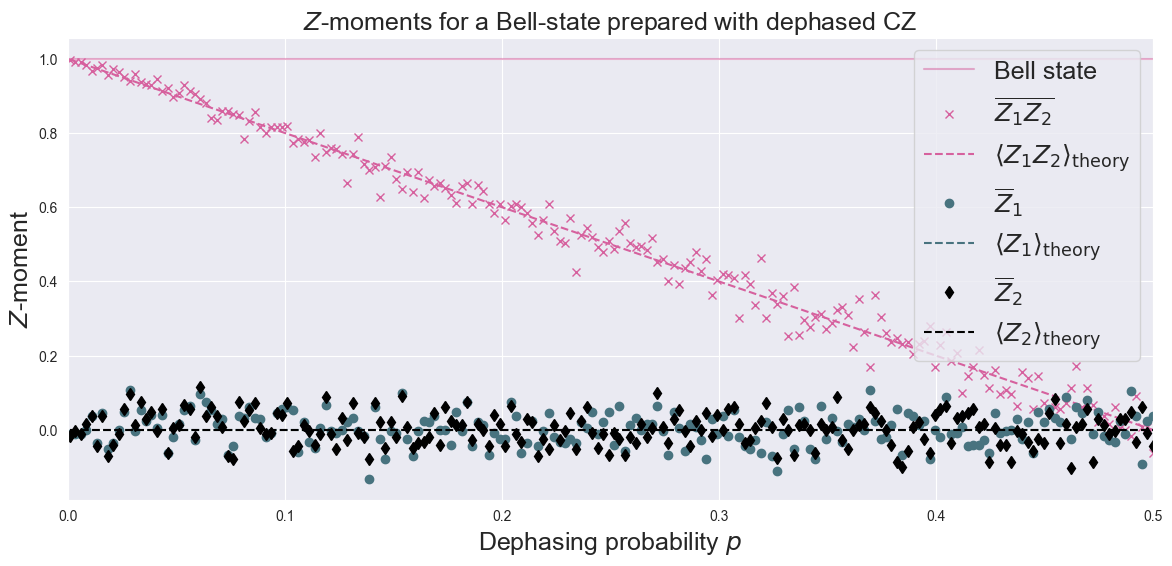

In [12]:
plt.figure(figsize=(14, 6))
plt.axhline(y=1.0, color=FUSCHIA, alpha=.5, label="Bell state")

plt.plot(ps, Z1Z2m, "x", c=FUSCHIA, label=r"$\overline{Z_1 Z_2}$")
plt.plot(ps, 1-2*ps, "--", c=FUSCHIA, label=r"$\langle Z_1 Z_2\rangle_{\rm theory}$")

plt.plot(ps, Z1m, "o", c=DARK_TEAL, label=r"$\overline{Z}_1$")
plt.plot(ps, 0*ps, "--", c=DARK_TEAL, label=r"$\langle Z_1\rangle_{\rm theory}$")

plt.plot(ps, Z2m, "d", c="k", label=r"$\overline{Z}_2$")
plt.plot(ps, 0*ps, "--", c="k", label=r"$\langle Z_2\rangle_{\rm theory}$")

plt.xlabel(r"Dephasing probability $p$", size=18)
plt.ylabel(r"$Z$-moment", size=18)
plt.title(r"$Z$-moments for a Bell-state prepared with dephased CZ", size=18)
plt.xlim(0, .5)
plt.legend(fontsize=18)

# Adding Decoherence Noise

In [13]:
from pyquil.quil import Program
from pyquil.paulis import PauliSum, PauliTerm, exponentiate, exponential_map, trotterize
from pyquil.gates import MEASURE, H, Z, RX, RZ, CZ
from pyquil.quilbase import Declare
import numpy as np

In [14]:
from numpy import pi
theta = pi/3
xy = PauliTerm('X', 0) * PauliTerm('Y', 1)

In [15]:
prog = exponential_map(xy)(theta)
print(prog)

H 0
RX(pi/2) 1
CNOT 0 1
RZ(2*pi/3) 1
CNOT 0 1
H 0
RX(-pi/2) 1



In [16]:
def get_compiled_prog(theta):
    return Program([
        RZ(-pi/2, 0),
        RX(-pi/2, 0),
        RZ(-pi/2, 1),
        RX( pi/2, 1),
        CZ(1, 0),
        RZ(-pi/2, 1),
        RX(-pi/2, 1),
        RZ(theta, 1),
        RX( pi/2, 1),
        CZ(1, 0),
        RX( pi/2, 0),
        RZ( pi/2, 0),
        RZ(-pi/2, 1),
        RX( pi/2, 1),
        RZ(-pi/2, 1),
    ])

## Scan Over Noise Parameters

fix - https://github.com/rigetti/pyquil/issues/1402

In [17]:
from pyquil import get_qc
qc = get_qc("2q-qvm")

In [18]:
t1s = np.logspace(-6, -5, num=3)
thetas = np.linspace(-pi, pi, num=20)
t1s * 1e6 # us

array([ 1.        ,  3.16227766, 10.        ])

In [19]:
from pyquil.noise import add_decoherence_noise
records = []
for theta in thetas:
    for t1 in t1s:
        prog = get_compiled_prog(theta)
        # noisy = add_decoherence_noise(prog, T1=t1).inst([
        noisy = add_decoherence_noise(prog, T1=t1, T2=2*t1).inst([
            Declare("ro", "BIT", 2),
            MEASURE(0, ("ro", 0)),
            MEASURE(1, ("ro", 1)),
        ])

        noisy.wrap_in_numshots_loop(1000)

        bitstrings = qc.run(noisy).readout_data.get("ro")

        # Expectation of Z0 and Z1
        z0, z1 = 1 - 2*np.mean(bitstrings, axis=0)

        # Expectation of ZZ by computing the parity of each pair
        zz = 1 - (np.sum(bitstrings, axis=1) % 2).mean() * 2

        record = {
            'z0': z0,
            'z1': z1,
            'zz': zz,
            'theta': theta,
            't1': t1,
        }
        records += [record]

## Plot the Results

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

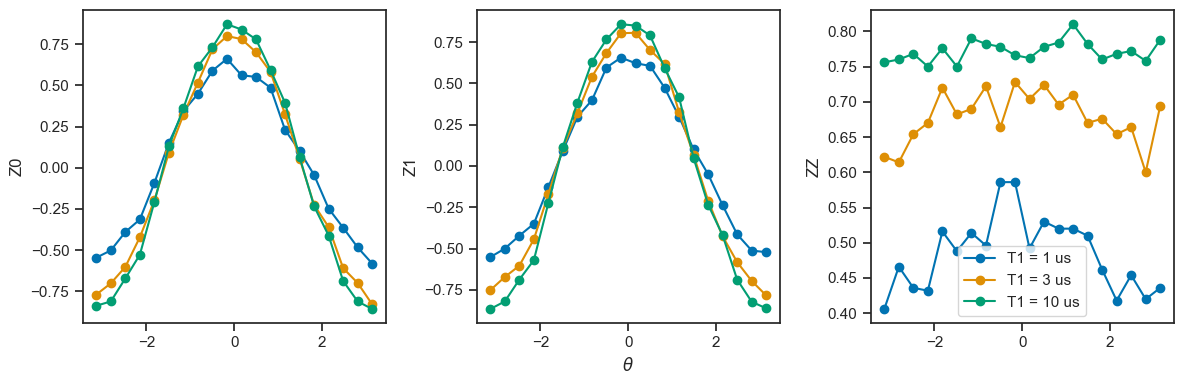

In [21]:
import pandas as pd
df_all = pd.DataFrame(records)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

for t1 in t1s:
    df = df_all.query('t1 == @t1')

    ax1.plot(df['theta'], df['z0'], 'o-')
    ax2.plot(df['theta'], df['z1'], 'o-')
    ax3.plot(df['theta'], df['zz'], 'o-', label='T1 = {:.0f} us'.format(t1*1e6))

ax3.legend(loc='best')

ax1.set_ylabel('Z0')
ax2.set_ylabel('Z1')
ax3.set_ylabel('ZZ')
ax2.set_xlabel(r'$\theta$')
fig.tight_layout()

# Working with Readout Noise

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyquil import get_qc
from pyquil.quil import Program, MEASURE, Pragma
from pyquil.gates import I, X, RX, H, CNOT
from pyquil.noise import (estimate_bitstring_probs, correct_bitstring_probs,
                          bitstring_probs_to_z_moments, estimate_assignment_probs)

DARK_TEAL = '#48737F'
FUSCHIA = '#D6619E'
BEIGE = '#EAE8C6'

qc = get_qc("1q-qvm")

In [33]:
%%time

# number of angles
num_theta = 101

# number of program executions
trials = 200

thetas = np.linspace(0, 2*np.pi, num_theta)

p00s = [1., 0.95, 0.9, 0.8]

results_rabi = np.zeros((num_theta, len(p00s)))

for jj, theta in enumerate(thetas):
    for kk, p00 in enumerate(p00s):
        qc.qam.random_seed = abs(hash((jj, kk)))
        p = Program(RX(theta, 0)).wrap_in_numshots_loop(trials)
        # assume symmetric noise p11 = p00
        p.define_noisy_readout(0, p00=p00, p11=p00)
        ro = p.declare("ro", "BIT", 1)
        p.measure(0, ro[0])
        res = qc.run(p).readout_data.get("ro")
        results_rabi[jj, kk] = np.sum(res)

CPU times: total: 891 ms
Wall time: 10.1 s


## Example 1: Rabi Sequence with Noisy Readout

In [36]:
%%time

# number of angles
num_theta = 101

# number of program executions
trials = 200

thetas = np.linspace(0, 2*np.pi, num_theta)

p00s = [1., 0.95, 0.9, 0.8]

results_rabi = np.zeros((num_theta, len(p00s)))

for jj, theta in enumerate(thetas):
    for kk, p00 in enumerate(p00s):
        # qc.qam.random_seed = hash((jj, kk))
        qc.qam.random_seed = abs(hash((jj, kk)))
        p = Program(RX(theta, 0)).wrap_in_numshots_loop(trials)
        # assume symmetric noise p11 = p00
        p.define_noisy_readout(0, p00=p00, p11=p00)
        ro = p.declare("ro", "BIT", 1)
        p.measure(0, ro[0])
        res = qc.run(p).readout_data.get("ro")
        results_rabi[jj, kk] = np.sum(res)

CPU times: total: 1.16 s
Wall time: 8.33 s


In [35]:
results_rabi

array([[  0.,   8.,  20.,  29.],
       [  1.,  11.,  17.,  37.],
       [  0.,  11.,  20.,  36.],
       [  5.,   9.,  24.,  31.],
       [  3.,  15.,  25.,  42.],
       [  3.,  13.,  29.,  46.],
       [  5.,  25.,  25.,  53.],
       [ 12.,  18.,  25.,  43.],
       [ 15.,  26.,  37.,  41.],
       [  7.,  27.,  30.,  55.],
       [ 19.,  29.,  36.,  48.],
       [ 31.,  35.,  40.,  60.],
       [ 29.,  36.,  43.,  49.],
       [ 38.,  43.,  43.,  51.],
       [ 38.,  50.,  45.,  46.],
       [ 43.,  55.,  59.,  64.],
       [ 49.,  40.,  63.,  71.],
       [ 50.,  64.,  66.,  62.],
       [ 62.,  49.,  71.,  83.],
       [ 58.,  66.,  72.,  74.],
       [ 76.,  81.,  76.,  86.],
       [ 67.,  75.,  81.,  88.],
       [ 82.,  65.,  84.,  81.],
       [ 77.,  83.,  91.,  94.],
       [ 83.,  89.,  95.,  97.],
       [103.,  88.,  97.,  90.],
       [ 95., 102., 108., 105.],
       [112., 107., 107.,  84.],
       [122., 110., 123., 107.],
       [125., 127., 125., 120.],
       [12

Text(0.5, 1.0, 'Effect of classical readout noise on Rabi contrast.')

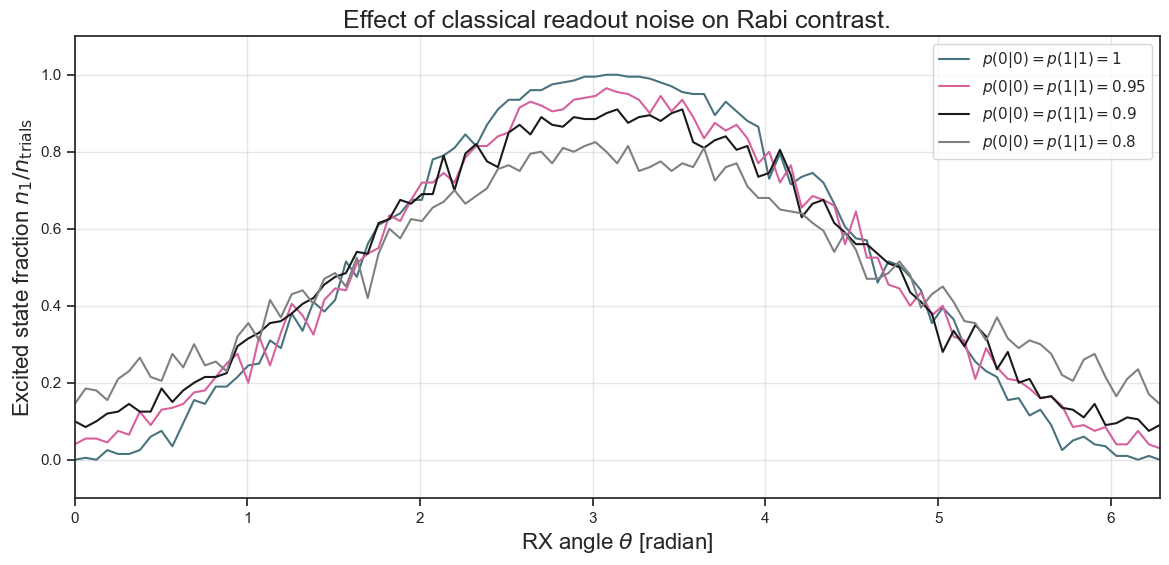

In [25]:
plt.figure(figsize=(14, 6))
for jj, (p00, c) in enumerate(zip(p00s, [DARK_TEAL, FUSCHIA, "k", "gray"])):
    plt.plot(thetas, results_rabi[:, jj]/trials, c=c, label=r"$p(0|0)=p(1|1)={:g}$".format(p00))
plt.legend(loc="best")
plt.xlim(*thetas[[0,-1]])
plt.ylim(-.1, 1.1)
plt.grid(alpha=.5)
plt.xlabel(r"RX angle $\theta$ [radian]", size=16)
plt.ylabel(r"Excited state fraction $n_1/n_{\rm trials}$", size=16)
plt.title("Effect of classical readout noise on Rabi contrast.", size=18)

## Example 2: Estimate the Assignment Probabilities

In [26]:
estimate_assignment_probs(0, 1000, qc)

array([[1., 0.],
       [0., 1.]])

In [27]:
qc.qam.random_seed = None
header0 = Program().define_noisy_readout(0, .85, .95)
header1 = Program().define_noisy_readout(1, .8, .9)
header2 = Program().define_noisy_readout(2, .9, .85)

ap0 = estimate_assignment_probs(0, 100000, qc, header0)
ap1 = estimate_assignment_probs(1, 100000, qc, header1)
ap2 = estimate_assignment_probs(2, 100000, qc, header2)

In [28]:
print(ap0, ap1, ap2, sep="\n")

[[0.85225 0.05005]
 [0.14775 0.94995]]
[[0.80012 0.09982]
 [0.19988 0.90018]]
[[0.89792 0.15021]
 [0.10208 0.84979]]


Example 3: Correct for Noisy Readout

In [29]:
ap_last = np.array([[p00s[-1], 1 - p00s[-1]],
                    [1 - p00s[-1], p00s[-1]]])
corrected_last_result = [correct_bitstring_probs([1-p, p], [ap_last])[1] for p in results_rabi[:, -1] / trials]

Text(0.5, 1.0, 'Corrected contrast')

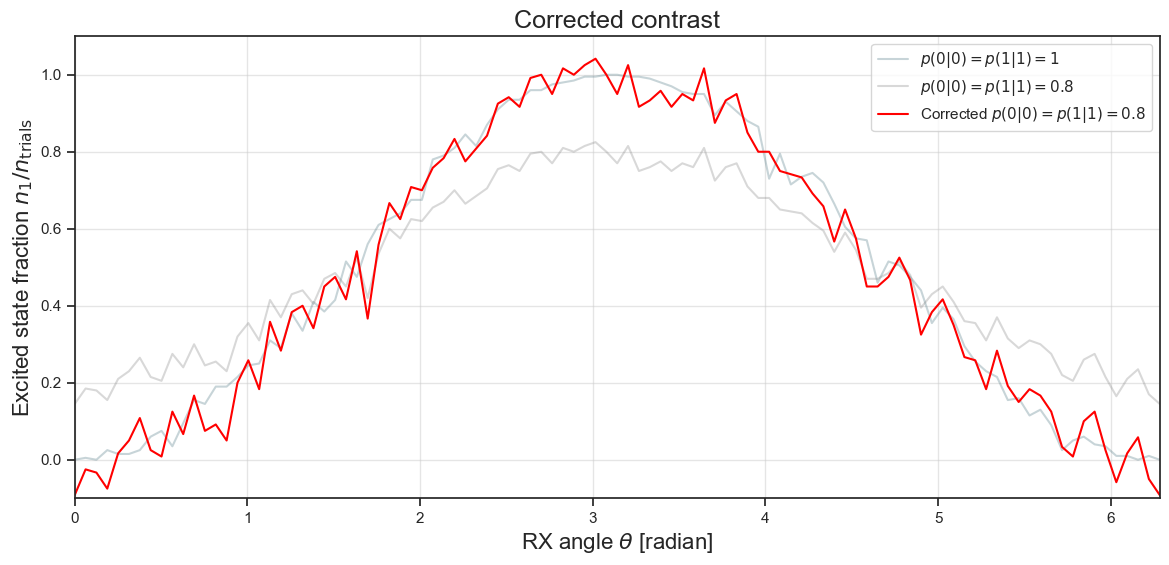

In [30]:
plt.figure(figsize=(14, 6))
for jj, (p00, c) in enumerate(zip(p00s, [DARK_TEAL, FUSCHIA, "k", "gray"])):
    if jj not in [0, 3]:
        continue
    plt.plot(thetas, results_rabi[:, jj]/trials, c=c, label=r"$p(0|0)=p(1|1)={:g}$".format(p00), alpha=.3)
plt.plot(thetas, corrected_last_result, c="red", label=r"Corrected $p(0|0)=p(1|1)={:g}$".format(p00s[-1]))
plt.legend(loc="best")
plt.xlim(*thetas[[0,-1]])
plt.ylim(-.1, 1.1)
plt.grid(alpha=.5)
plt.xlabel(r"RX angle $\theta$ [radian]", size=16)
plt.ylabel(r"Excited state fraction $n_1/n_{\rm trials}$", size=16)
plt.title("Corrected contrast", size=18)

### 3b) Corrupting and Correcting GHZ State Correlations

In [31]:
ghz_prog = Program(
    Declare("ro", "BIT", 3),
    H(0), CNOT(0, 1), CNOT(1, 2),
    MEASURE(0, ("ro", 0)), MEASURE(1, ("ro", 1)), MEASURE(2, ("ro", 2)),
)
ghz_prog.wrap_in_numshots_loop(10000)
print(ghz_prog)
results = qc.run(ghz_prog).readout_data.get("ro")

DECLARE ro BIT[3]
H 0
CNOT 0 1
CNOT 1 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]



In [32]:
header = header0 + header1 + header2
noisy_ghz = header + ghz_prog
noisy_ghz.wrap_in_numshots_loop(10000)
print(noisy_ghz)
noisy_results = qc.run(noisy_ghz).readout_data.get("ro")

PRAGMA READOUT-POVM 0 "(0.85 0.050000000000000044 0.15000000000000002 0.95)"
PRAGMA READOUT-POVM 1 "(0.8 0.09999999999999998 0.19999999999999996 0.9)"
PRAGMA READOUT-POVM 2 "(0.9 0.15000000000000002 0.09999999999999998 0.85)"
DECLARE ro BIT[3]
H 0
CNOT 0 1
CNOT 1 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]

